# Modelos de predicción

In [1]:
import pandas as pd
import numpy as np
#Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#Para evitar alertas
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("data_preprocessed.csv")
df.iloc[np.random.randint(0,df.shape[0],10),:]

,price,rooms,lift,terrace,square_meters,real_state,neighborhood,square_meters_price
2471,1250,3,1,1,80,2,4,15.6250
1325,785,2,1,0,50,2,7,15.7000
1730,690,2,1,0,56,2,3,12.3214
4949,880,3,0,0,70,2,1,12.5714
3045,880,3,0,0,68,2,8,12.9412
6769,850,2,0,0,66,2,1,12.8788
6094,1350,3,1,1,80,0,1,16.8750
7453,1000,3,0,0,75,2,9,13.3333
921,1250,3,1,0,115,2,1,10.8696
7393,1825,3,1,0,91,2,1,20.0549


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180 entries, 0 to 8179
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                8180 non-null   int64  
 1   rooms                8180 non-null   int64  
 2   lift                 8180 non-null   int64  
 3   terrace              8180 non-null   int64  
 4   square_meters        8180 non-null   int64  
 5   real_state           8180 non-null   int64  
 6   neighborhood         8180 non-null   int64  
 7   square_meters_price  8180 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 511.4 KB


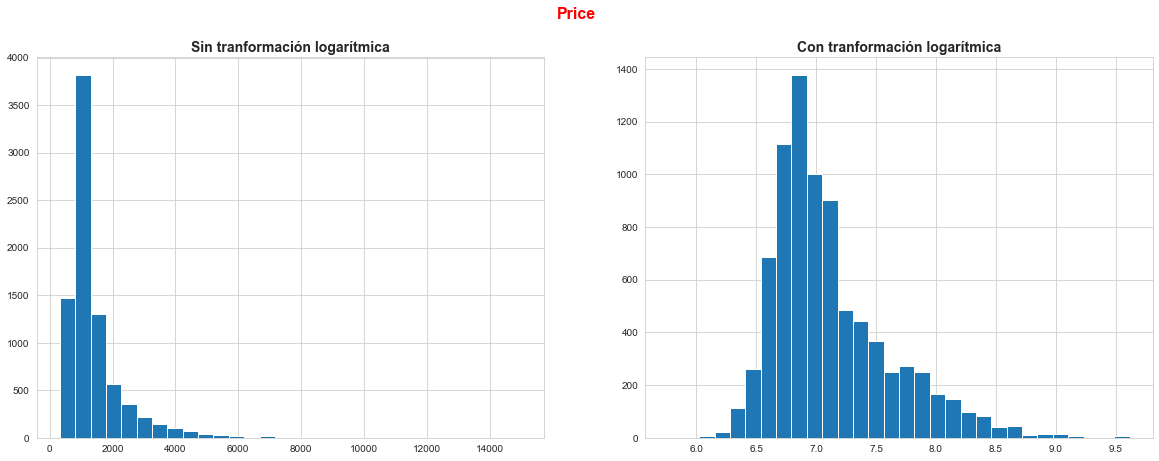

In [4]:
fig,ax=plt.subplots(1,2,figsize=(20,7))
ax[0].hist(df.price,bins=30)
ax[0].set_title('Sin tranformación logarítmica',fontsize=14,fontweight="bold")
ax[1].hist(np.log(df.price),bins=30)
ax[1].set_title('Con tranformación logarítmica', fontsize=14 ,fontweight="bold")
plt.suptitle("Price",fontsize=16,color="red",fontweight="bold")
plt.show()

Haciendo la partición de los datos:

In [5]:
from sklearn.model_selection import train_test_split,cross_validate
train , test = train_test_split(df,test_size=0.2,random_state=141) 
print(f"train:\t{len(train)}\ntest:\t{len(test)}")

train:	6544
test:	1636


Estableciendo la columna objetivo en `train` y `test`:

In [6]:
for dfp in ["train","test"]:
    exec("{0}_x={0}.drop(columns='price')".format(dfp))
    exec("{0}_y={0}.price".format(dfp))

In [7]:
#títulos of gráficos 
curv_val="Curva de validación"
curv_val_trans="Curva de validación con target transformada"

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
main_kfold = KFold(10, shuffle=True, random_state=45)
from sklearn.compose import TransformedTargetRegressor

### Regresión linear simple

In [9]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', LinearRegression(n_jobs=-1))])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 2.11 s


Pipeline(steps=[('scale', RobustScaler()), ('lr', LinearRegression(n_jobs=-1))])

In [10]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 163.02


In [11]:
predict_y=lr_pipe.predict(test_x)
error_rl=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_rl)

Test: 165.17


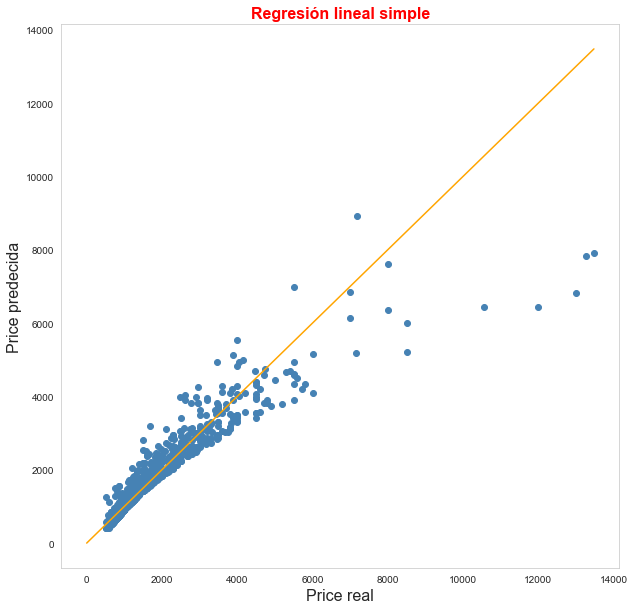

In [12]:
plt.figure(figsize=(10,10))
plt.title("Regresión lineal simple",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

Con tranformación logarítmica:

In [13]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 942 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr',
                                                      LinearRegression(n_jobs=-1))]))

In [14]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 298.09


In [15]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 256.03


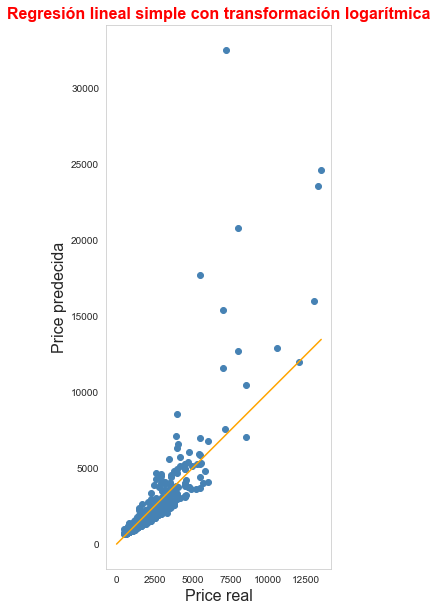

In [16]:
plt.figure(figsize=(10,10))
plt.title("Regresión lineal simple con transformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

### Lasso

In [17]:
%%time
from sklearn.linear_model import Lasso
clf = Lasso()
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', clf)])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 57.9 ms


Pipeline(steps=[('scale', RobustScaler()), ('lr', Lasso())])

In [18]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 162.57


In [19]:
predict_y=lr_pipe.predict(test_x)
error_lasso=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_lasso)

Test: 164.9


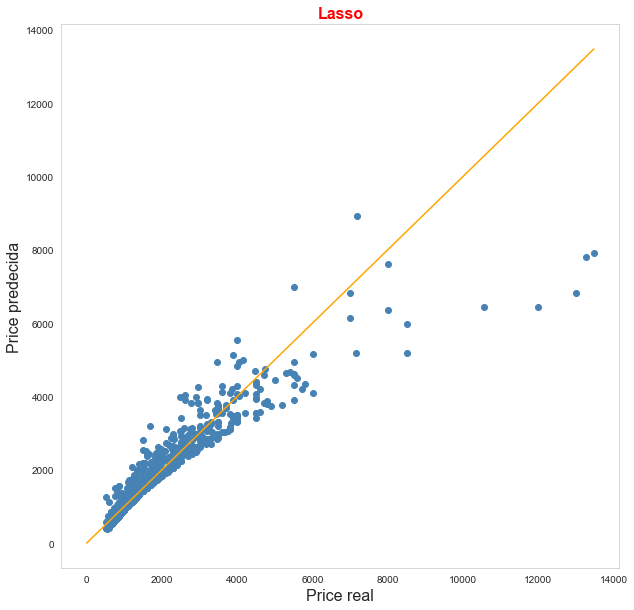

In [20]:
plt.figure(figsize=(10,10))
plt.title("Lasso",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show() 

Con transformación logarítmica:

In [21]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 46.3 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr', Lasso())]))

In [22]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 575.53


In [23]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 612.61


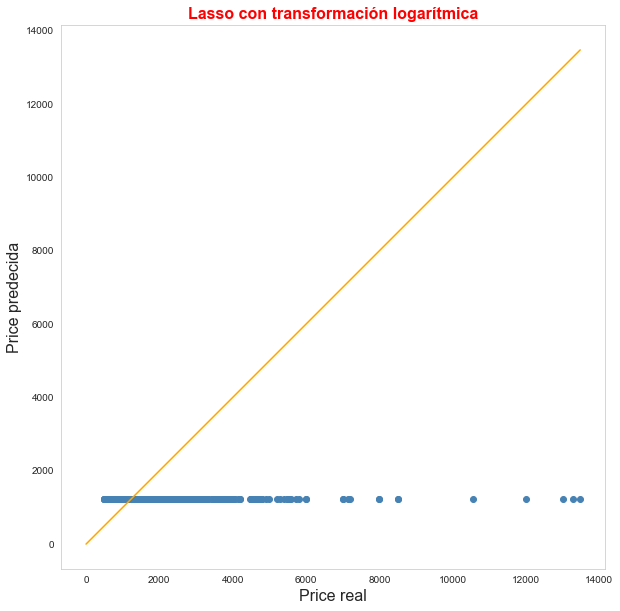

In [24]:
plt.figure(figsize=(10,10))
plt.title("Lasso con transformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

### Ridge

In [25]:
%%time
from sklearn.linear_model import Ridge
clf = Ridge()
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', clf)])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 36.5 ms


Pipeline(steps=[('scale', RobustScaler()), ('lr', Ridge())])

In [26]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 163.0


In [27]:
predict_y=lr_pipe.predict(test_x)
error_ridge=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_ridge)

Test: 165.15


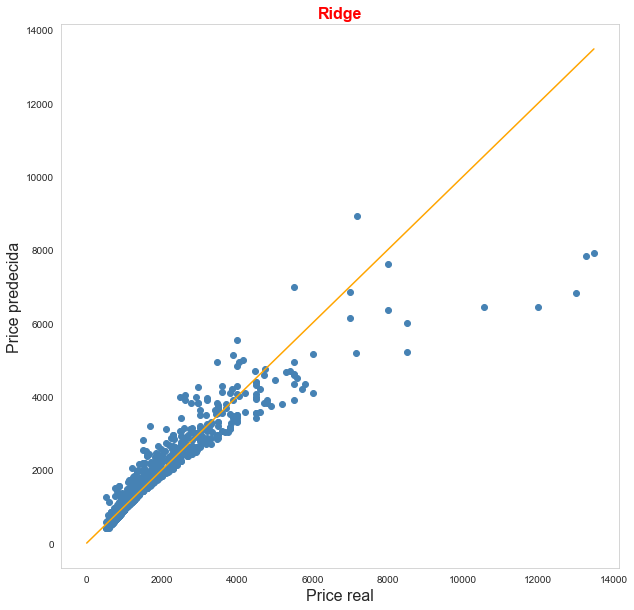

In [28]:
plt.figure(figsize=(10,10))
plt.title("Ridge",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show() 

Con tranformación logarítmica:

In [29]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 43.8 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr', Ridge())]))

In [30]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 298.05


In [31]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 256.0


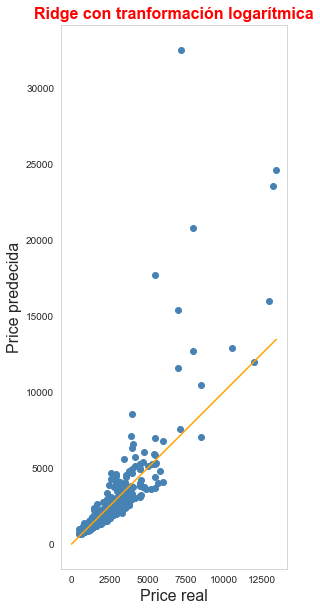

In [32]:
plt.figure(figsize=(10,10))
plt.title("Ridge con tranformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### ElasticNet

In [33]:
%%time
from sklearn.linear_model import ElasticNet
clf = ElasticNet()
lr_pipe = Pipeline([('scale', RobustScaler()),('lr', clf)])

scoring = {'nmae': 'neg_mean_absolute_error',
           'nmse': 'neg_mean_squared_error',
           'r2': 'r2'}

lr_scores = cross_validate(lr_pipe, train_x, train_y,
                           scoring=scoring, cv=main_kfold,
                           return_train_score=True, return_estimator=True, n_jobs=-1)
lr_pipe.fit(train_x, train_y)

Wall time: 37 ms


Pipeline(steps=[('scale', RobustScaler()), ('lr', ElasticNet())])

In [34]:
print('Train:', -lr_scores['train_nmae'].mean().round(2))

Train: 214.12


In [35]:
predict_y=lr_pipe.predict(test_x)
error_elasticnet=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_elasticnet)

Test: 223.51


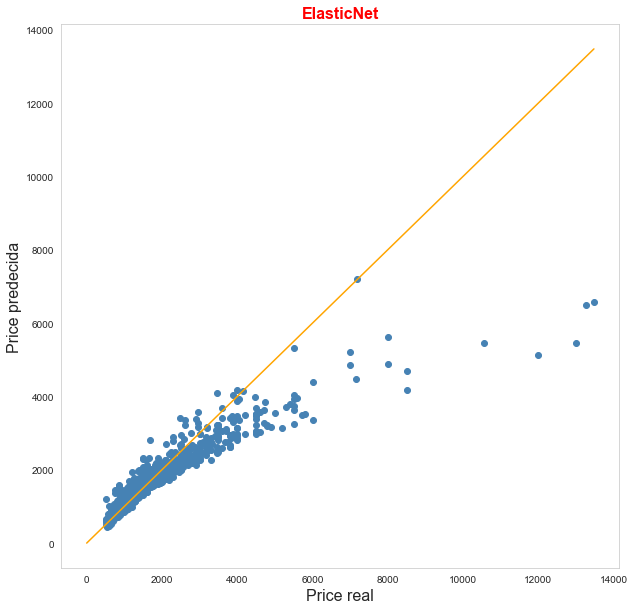

In [36]:
plt.figure(figsize=(10,10))
plt.title("ElasticNet",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
#plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show() 

Con transformación logarítmica

In [37]:
%%time
lr_trans = TransformedTargetRegressor(lr_pipe,func=np.log,inverse_func=np.exp)
lr_trans_scores = cross_validate(lr_trans, train_x, train_y,
                                 scoring=scoring, cv=main_kfold,
                                 return_train_score=True, return_estimator=True, n_jobs=-1)
#Ajuste del modelo 
lr_trans.fit(train_x, train_y)

Wall time: 48.4 ms


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('scale', RobustScaler()),
                                                     ('lr', ElasticNet())]))

In [38]:
print('Train:', -lr_trans_scores['train_nmae'].mean().round(2))

Train: 575.53


In [39]:
predict_y=lr_trans.predict(test_x)
predict_y[predict_y==np.inf]=predict_y[predict_y!=np.inf].max()
print("Test:",mean_absolute_error(predict_y,test_y).round(2))

Test: 612.61


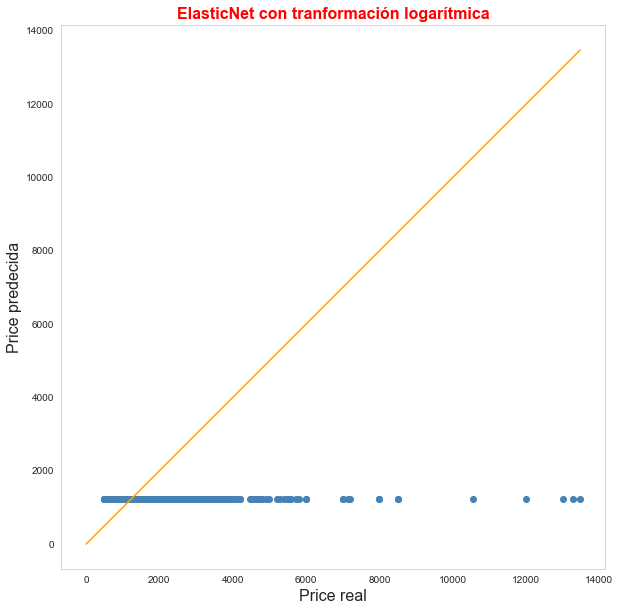

In [40]:
plt.figure(figsize=(10,10))
plt.title("ElasticNet con tranformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

### K-Nearest Neighboor

In [41]:
%%time
n_neighbors= np.arange(3,25,2)
from sklearn.neighbors import KNeighborsRegressor

#Creando un modelo
knn = KNeighborsRegressor(p=1,n_jobs=-1)
#Creando un diccionario donde queremos evaluar n_neighbors
param_grid = {"n_neighbors": n_neighbors}
#Usando gridsearch para evaluar todos los valores de n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#Ajustando el modelo 
knn_gscv.fit(train_x, train_y)

Wall time: 431 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

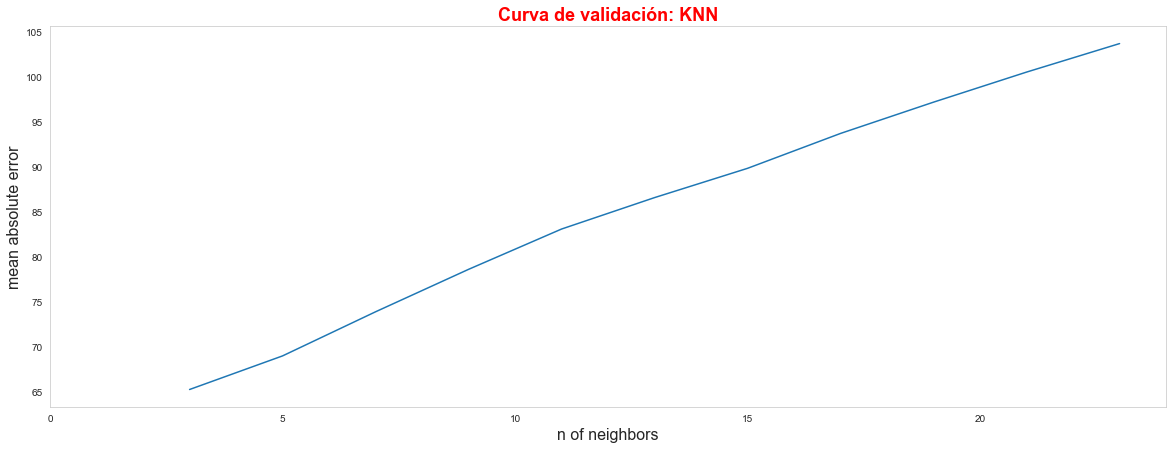

In [42]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv.cv_results_['mean_test_score']) 
plt.title(curv_val+": KNN",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [43]:
predict_y=knn_gscv.predict(test_x)
error_knn=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_knn)

Test: 68.59


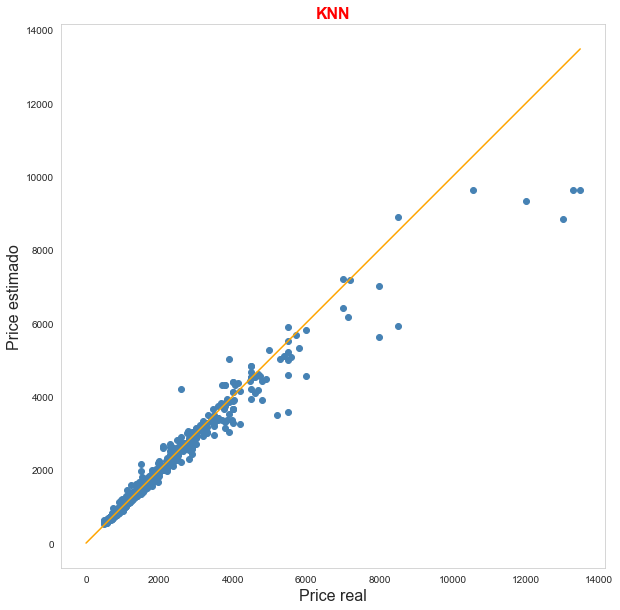

In [44]:
plt.figure(figsize=(10,10))
plt.title("KNN",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price estimado',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

Con tranformación logarítmica

In [45]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(knn,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_neighbors':n_neighbors}
knn_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
knn_gscv_trans.fit(train_x, train_y)

Wall time: 436 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=KNeighborsRegressor(n_jobs=-1,
                                                                                                 p=1)))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='neg_mean_absolute_error')

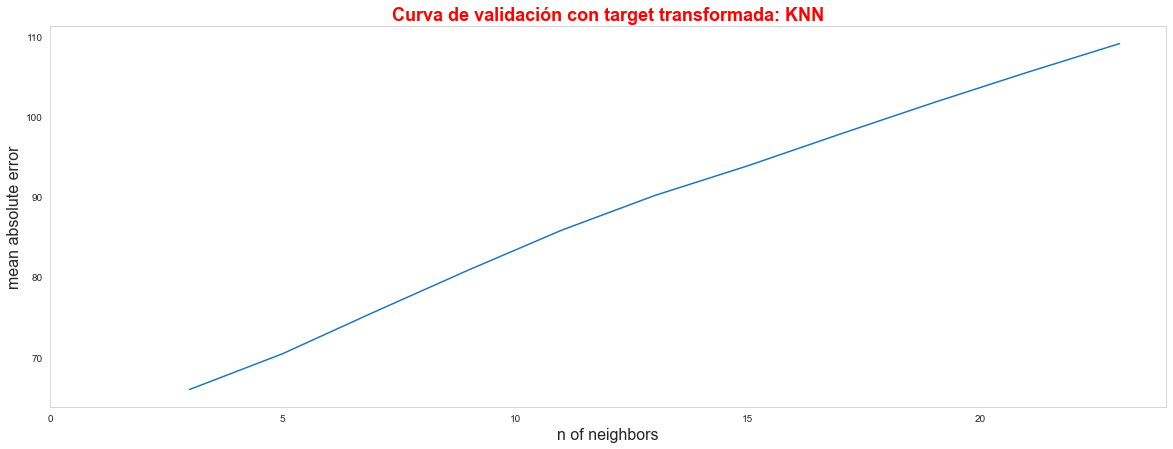

In [46]:
plt.figure(figsize=(20,7))
plt.plot(n_neighbors, -knn_gscv_trans.cv_results_['mean_test_score']) 
plt.title(curv_val_trans +": KNN",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of neighbors',fontsize=16)
plt.xticks(np.arange(0,25,step=5))
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [47]:
predict_y=knn_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 70.5


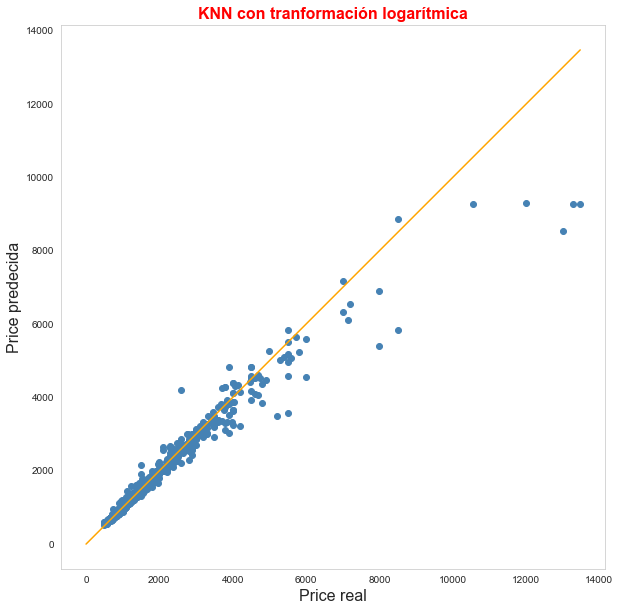

In [48]:
plt.figure(figsize=(10,10))
plt.title("KNN con tranformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

### Random Forest

In [49]:
%%time
N=np.array([15,50,100,250,300,350])
from sklearn.ensemble import RandomForestRegressor 

#Creando un modelo
rf = RandomForestRegressor(n_jobs=-1)
#Creando un diccionario de todos los valores que queremos evaluar para n_neighbors
param_grid = {"n_estimators": N}

#Usando gridsearch para evaluar todos los valores para n_neighbors
rf_gscv = GridSearchCV(rf, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#Ajustando el modelo
rf_gscv.fit(train_x, train_y)

Wall time: 13 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 250, 300, 350])},
             scoring='neg_mean_absolute_error')

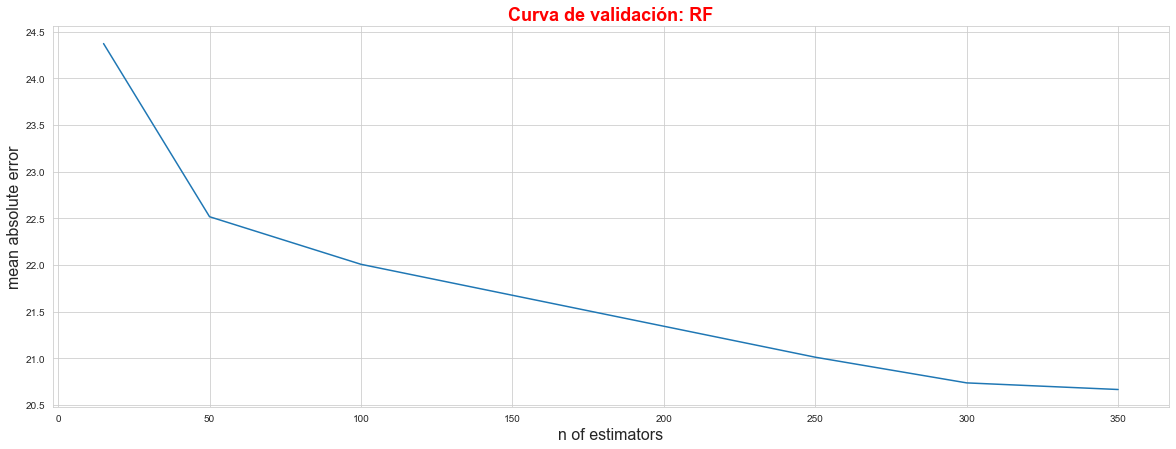

In [50]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv.cv_results_['mean_test_score']) 
plt.title(curv_val + ": RF",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [51]:
predict_y=rf_gscv.predict(test_x)
error_rf=mean_absolute_error(predict_y,test_y).round(2)
print("Test:",error_rf)

Test: 22.74


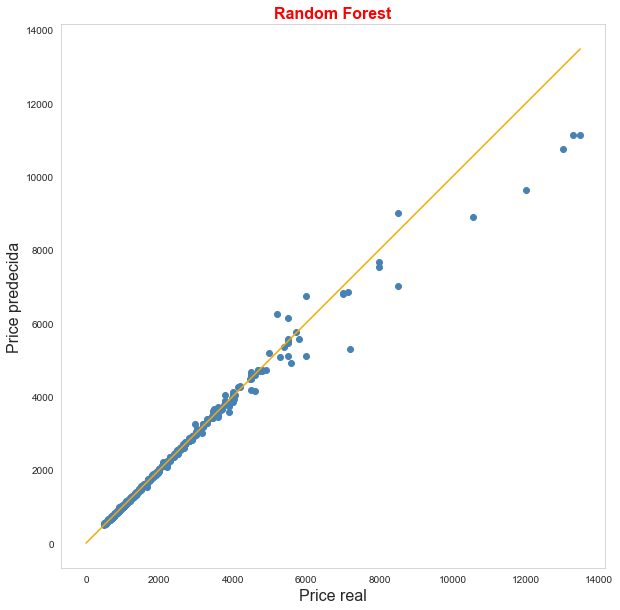

In [52]:
plt.figure(figsize=(10,10))
plt.title("Random Forest",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()

Con transformación logarítmica:

In [53]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(rf,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_estimators':N}
rf_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
rf_gscv_trans.fit(train_x, train_y)

Wall time: 12.7 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor(n_jobs=-1)))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_estimators': array([ 15,  50, 100, 250, 300, 350])},
             scoring='neg_mean_absolute_error')

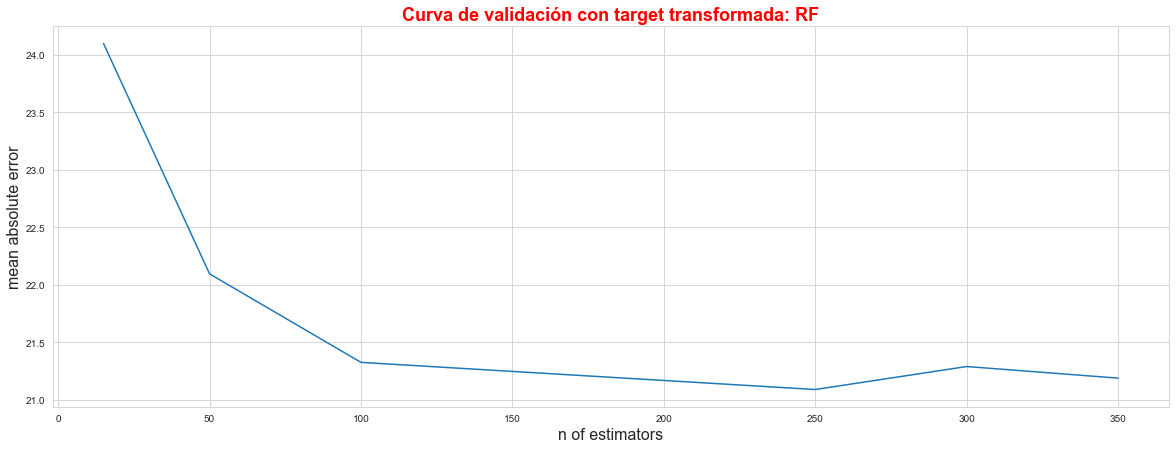

In [54]:
plt.figure(figsize=(20,7))
plt.plot(N, -rf_gscv_trans.cv_results_['mean_test_score']) 
plt.title(curv_val_trans +": RF",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.ylabel('mean absolute error',fontsize=16)
plt.show() 

In [55]:
predict_y=rf_gscv_trans.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 24.03


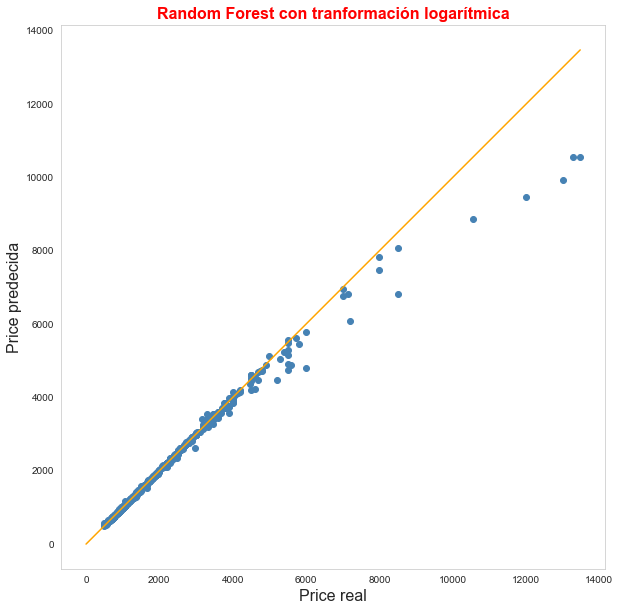

In [56]:
plt.figure(figsize=(10,10))
plt.title("Random Forest con tranformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

### Gradient Boosting

In [57]:
%%time
N=np.array([15,50,100,300,500,800])
from sklearn.ensemble import GradientBoostingRegressor 
#Creando el modelo
gb = GradientBoostingRegressor()
param_grid = {'n_estimators': N}
#Usando gridsearch para evaluar todos los valores
gb_gscv = GridSearchCV(gb, param_grid, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
#Ajustando el modelo
gb_gscv.fit(train_x, train_y)

Wall time: 9.99 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'n_estimators': array([ 15,  50, 100, 300, 500, 800])},
             scoring='neg_mean_absolute_error')

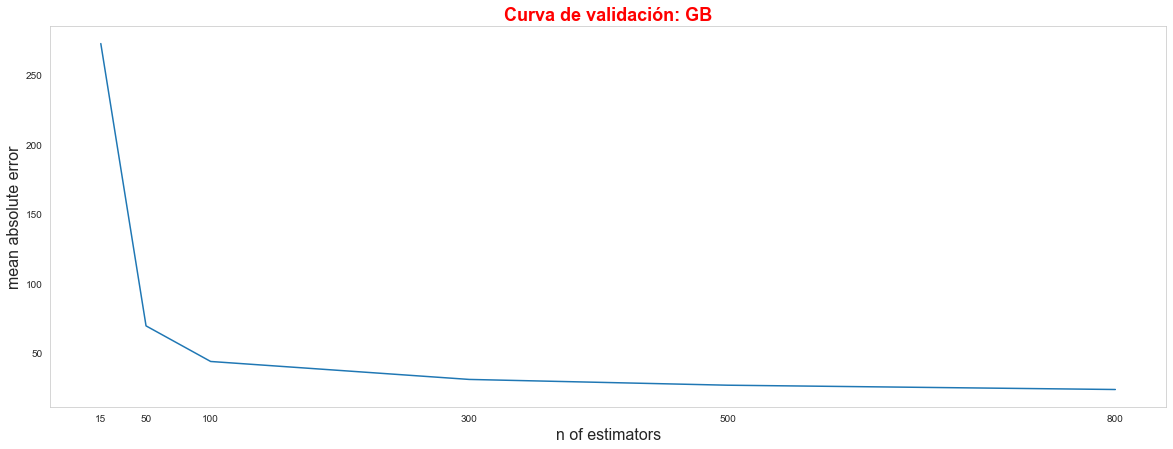

In [58]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv.cv_results_['mean_test_score']) 
plt.title(curv_val +": GB",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(N)
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()   

In [59]:
predict_y=gb_gscv.predict(test_x)
print("Test:",mean_absolute_error(test_y,predict_y).round(2))

Test: 22.52


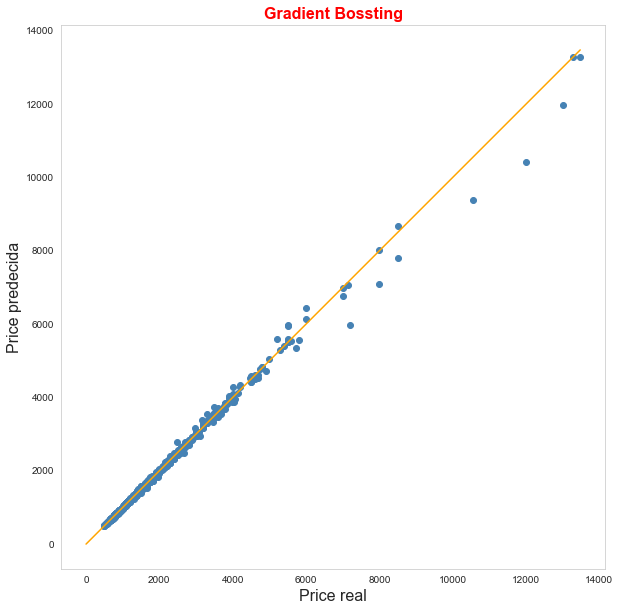

In [60]:
plt.figure(figsize=(10,10))
plt.title("Gradient Bossting",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price predecida',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()    

Con tranformación logarítmica:

In [61]:
%%time
model_pipe = Pipeline([('model', TransformedTargetRegressor(gb,func=np.log,inverse_func=np.exp))])
params_grid_trans={'model__regressor__n_estimators':N}
gb_gscv_trans = GridSearchCV(model_pipe, params_grid_trans, cv=main_kfold,scoring='neg_mean_absolute_error',n_jobs=-1)
gb_gscv_trans.fit(train_x, train_y)

Wall time: 10.6 s


GridSearchCV(cv=KFold(n_splits=10, random_state=45, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=GradientBoostingRegressor()))]),
             n_jobs=-1,
             param_grid={'model__regressor__n_estimators': array([ 15,  50, 100, 300, 500, 800])},
             scoring='neg_mean_absolute_error')

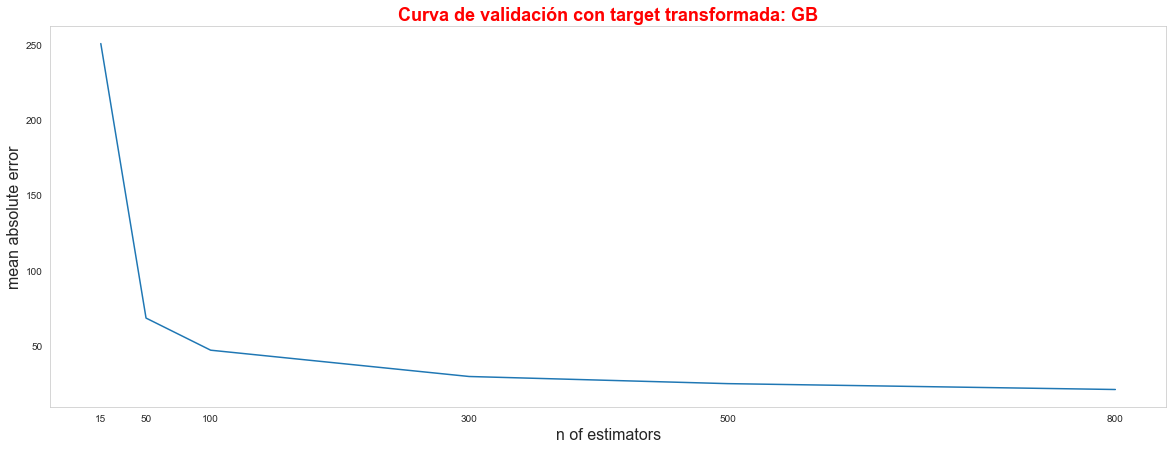

In [62]:
plt.figure(figsize=(20,7))
plt.plot(N, -gb_gscv_trans.cv_results_['mean_test_score']) 
plt.title(curv_val_trans +": GB",fontsize=18,color='red',fontweight="bold")
plt.xlabel('n of estimators',fontsize=16)
plt.xticks(N)
plt.ylabel('mean absolute error',fontsize=16)
plt.grid(ls='--',lw=0.7) 
plt.show()    

In [63]:
predict_y=gb_gscv_trans.predict(test_x)
error_gb=mean_absolute_error(test_y,predict_y).round(2)
print("Test:",error_gb)

Test: 20.7


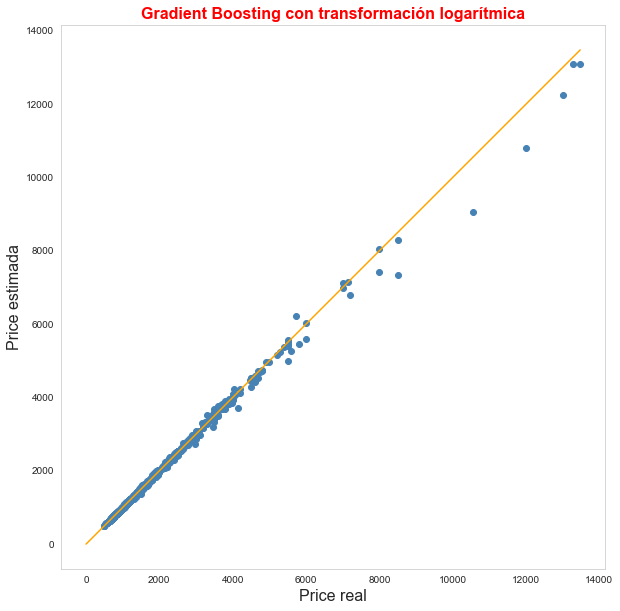

In [64]:
plt.figure(figsize=(10,10))
plt.title("Gradient Boosting con transformación logarítmica",fontsize=16,color='red',fontweight="bold")
plt.scatter(test_y, predict_y,color="steelblue") 
plt.plot(range(test_y.max()),range(test_y.max()),color="orange")
plt.axis('scaled')
plt.xlabel('Price real',fontsize=16)
plt.ylabel('Price estimada',fontsize=16)
plt.grid(ls='--',lw=0.7)    
plt.show()  

- Es el único método que ofrece una mejor calidad con la transformación logarítmica.
- El único handicap es el tiempo de cálculo para volumenes más grandes.
### Resumen

In [65]:
#Customizando el texto
class color:
   DARKCYAN = '\033[36m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [66]:
metodos=["rl","lasso","elasticnet","knn","rf","gb"]
sentencia_tl=["No"]*5 + ["Sí"]
print(color.DARKCYAN + color.UNDERLINE + color.BOLD+"RESUMEN:" + color.END)
print(color.BOLD + "Métodos".ljust(14),"Error medio (en euros)".ljust(23)+ "¿Ayuda la transformación logarítmica?"+ color.END)
for met,bol in zip(metodos,sentencia_tl):
    print(met.upper().ljust(14),str(eval(f"error_{met}")).ljust(22),bol)

RESUMEN:
Métodos        Error medio (en euros) ¿Ayuda la transformación logarítmica?
RL             165.17                 No
LASSO          164.9                  No
ELASTICNET     223.51                 No
KNN            68.59                  No
RF             22.74                  No
GB             20.7                   Sí
